<a href="https://colab.research.google.com/github/islam-mirajul/Fake-Hilsa-Fish-Detection-Using-CNN/blob/main/Fake-Hilsa-Detection(NASNetMobile).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
print("TF Version:", tf.__version__)

TF Version: 2.2.0


In [ ]:
import tensorflow_hub as hub
print("TF hub Version:", hub.__version__)



TF hub Version: 0.8.0


In [ ]:
print("GPU", "availabe" if tf.config.list_physical_devices("GPU") else "not availabe")

GPU availabe


In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2967116549865426275, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1314695084243225670
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11281979199028160202
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14648777152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3795362394556416711
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [ ]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop

from keras.models import Model

from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.applications.nasnet import NASNetMobile

from keras.optimizers import Adam

from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [ ]:
output_classes = 2
batch_size = 16
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 5
nb_train_samples =2500
nb_test_samples =500

In [ ]:

train_dir = '/content/drive/My Drive/Project-data-shape-2/train'
test_dir = '/content/drive/My Drive/Project-data-shape-2/test'

In [ ]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))


print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

/content/drive/My Drive/Project-data-shape-2/train 0
/content/drive/My Drive/Project-data-shape-2/train/Fake-Hilsa-Fish 6320
******************************
/content/drive/My Drive/Project-data-shape-2/test 0
/content/drive/My Drive/Project-data-shape-2/test/Hilsa-Fish 1741
/content/drive/My Drive/Project-data-shape-2/test/Fake-Hilsa-Fish 1580


In [ ]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')


test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 13301 images belonging to 2 classes.
Found 3321 images belonging to 2 classes.


In [ ]:

base_model = NASNetMobile(weights='imagenet', include_top=False, input_tensor=Input(shape=input_shape))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
prediction = Dense(output_classes, activation=tf.nn.softmax)(x)

model = Model(inputs=base_model.input,outputs=prediction)

19996672/19993432 [==============================] - 1s 0us/step


In [ ]:
sgd_opt = SGD(lr = 0.02, decay=75e-6, momentum=0.9, nesterov=True)
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
sgd_opt = SGD(lr=1e-06, momentum=0.0, decay=0.0, nesterov=False)
rmsp_opt = RMSprop(lr=1e-4, decay=0.9)
eve_opt = Eve(lr=1e-4, decay=1E-4, beta_1=0.9, beta_2=0.999, beta_3=0.999, small_k=0.1, big_K=10, epsilon=1e-08)

model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 32) 128         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 32) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [ ]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/5
156/156 [==============================] - 162s 1s/step - loss: 0.4064 - accuracy: 0.8262 - val_loss: 0.1068 - val_accuracy: 0.9698
Epoch 2/5
156/156 [==============================] - 198s 1s/step - loss: 0.3896 - accuracy: 0.8357 - val_loss: 0.2801 - val_accuracy: 0.9597
Epoch 3/5
156/156 [==============================] - 165s 1s/step - loss: 0.3371 - accuracy: 0.8594 - val_loss: 0.0419 - val_accuracy: 0.9758
Epoch 4/5
156/156 [==============================] - 211s 1s/step - loss: 0.3149 - accuracy: 0.8734 - val_loss: 0.2961 - val_accuracy: 0.8024
Epoch 5/5
156/156 [==============================] - 240s 2s/step - loss: 0.2812 - accuracy: 0.8910 - val_loss: 0.5456 - val_accuracy: 0.7802


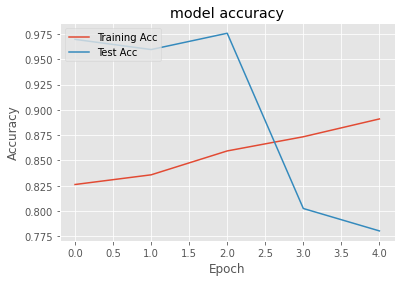

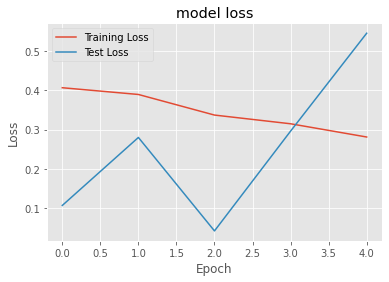

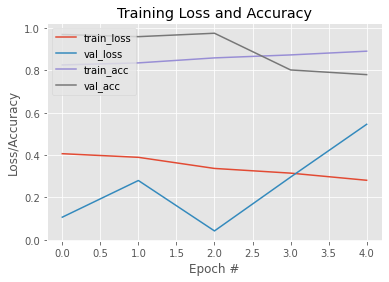

In [ ]:
plt.style.use("ggplot")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

In [ ]:
score = model.evaluate_generator(test_generator, steps=5)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.022678548470139503
Validation Accuracy:  0.9750000238418579


In [ ]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

208/207 [==============================] - 855s 4s/step
No of errors = 440/3321


Confusion Matrix
[[1550   30]
 [ 410 1331]]


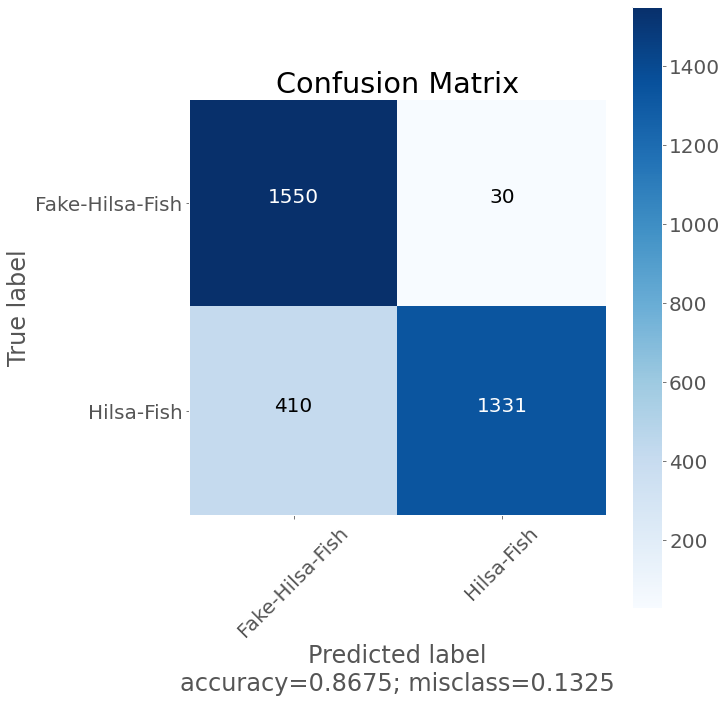

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    ##plt.savefig('plots/12.DenseNet-DataSet-CM.png', bbox_inches='tight', dpi = 100) 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[1550   30]
 [ 410 1331]]
                 precision    recall  f1-score   support

Fake-Hilsa-Fish       0.79      0.98      0.88      1580
     Hilsa-Fish       0.98      0.76      0.86      1741

       accuracy                           0.87      3321
      macro avg       0.88      0.87      0.87      3321
   weighted avg       0.89      0.87      0.87      3321



In [ ]:
total=sum(sum(cm))

accuracy = (cm[0,0]+cm[1,1]) / total
print ('Accuracy : ', accuracy)

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity )

Accuracy :  0.8675097862089732
Sensitivity :  0.7908163265306123
Specificity :  0.9779573842762674


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

th = 0.3

acc = accuracy_score(truth,predict_class > th)
prec = precision_score(truth,predict_class > th)
f1 = f1_score(truth,predict_class > th)
recall = recall_score(truth,predict_class > th)

print('Accuracy:  {:.4f}'.format(acc))
print('Precision: {:.4f}'.format(prec))
print('Recall:    {:.4f}'.format(recall))
print('F1:        {:.4f}'.format(f1))

Accuracy:  0.8675
Precision: 0.9780
Recall:    0.7645
F1:        0.8582


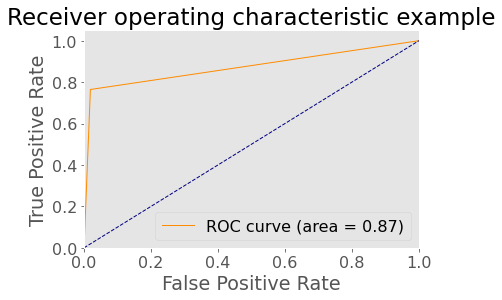

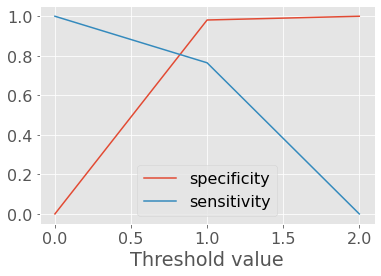

In [ ]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 16})

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(test_generator.classes, predict_class)
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt

plt.figure()
lw = 1
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#plotting sensitivity and specificity
plt.figure()
plt.plot(thresholds, 1-fpr, label = 'specificity')
plt.plot(thresholds, tpr, label = 'sensitivity')
plt.legend()
plt.grid()
plt.xlabel('Threshold value')
plt.show()

In [ ]:
model.save('/content/drive/My Drive/model/12.NASNetMobile(half_data)-hilsa-DataSet-Model.h5')
model.save_weights('/content/drive/My Drive/model/12.NASNetMobile(half-data)-hilsa-Weights.h5')